## Setup, Loading Data and CDFs

In [76]:
DATA_NAME = 'agriVision-full' 
TRANSFORM = 'wavelet'
CHANNEL = 'blue'

In [77]:
path_list = DATA_NAME.split("-") + TRANSFORM.split("-")
if CHANNEL:
    path_list.append(CHANNEL)
print(f"Name the notebook:\n{'_'.join(path_list[::-1])}.ipynb")

Name the notebook:
blue_wavelet_full_agriVision.ipynb


In [78]:
DATA_NAME='-'.join(path_list)

In [79]:
r_values = [0.5, 1, 1.5]
eta_values = [1, 2, 3]
scale_values = [1, 2, 3]

for r in r_values:
    for eta in eta_values:
        for scale in scale_values:
            test = sample_prior(r, eta, size=100000, scale=scale)
            emp_MAD = np.mean(np.abs(test - np.mean(test)))
            predicted_MAD = MAD_prior(r, eta, scale=scale)
            print(f"r: {r}, eta: {eta}, scale: {scale}")
            print(f"Empirical MAD: {emp_MAD}")
            print(f"Predicted MAD: {predicted_MAD}")
            print("-" * 30)

r: 0.5, eta: 1, scale: 1
Empirical MAD: 4.006815731803669
Predicted MAD: 3.989422804014327
------------------------------
r: 0.5, eta: 1, scale: 2
Empirical MAD: 5.672528526084834
Predicted MAD: 5.6418958354775635
------------------------------
r: 0.5, eta: 1, scale: 3
Empirical MAD: 6.91100292641597
Predicted MAD: 6.90988298942671
------------------------------
r: 0.5, eta: 2, scale: 1
Empirical MAD: 5.565963999930781
Predicted MAD: 5.585191925620058
------------------------------
r: 0.5, eta: 2, scale: 2
Empirical MAD: 7.865492565891787
Predicted MAD: 7.898654169668589
------------------------------
r: 0.5, eta: 2, scale: 3
Empirical MAD: 9.695577639525945
Predicted MAD: 9.673836185197395
------------------------------
r: 0.5, eta: 3, scale: 1
Empirical MAD: 7.174550914485976
Predicted MAD: 7.1809610472257885
------------------------------
r: 0.5, eta: 3, scale: 2
Empirical MAD: 10.152581801272776
Predicted MAD: 10.155412503859614
------------------------------
r: 0.5, eta: 3, scale:

In [80]:
import git
from pathlib import Path
import os

ROOT_DIR = Path(git.Repo('.', search_parent_directories=True).working_tree_dir)
CWD = os.path.join(ROOT_DIR, "results", "case-studies", *path_list)

assert CWD == os.getcwd()
Path(os.path.join(CWD, "CSVs")).mkdir(exist_ok=True)
Path(os.path.join(CWD, "plots")).mkdir(exist_ok=True)
Path(os.path.join(CWD, "cache")).mkdir(exist_ok=True)
Path(os.path.join(CWD, "groupCDFs")).mkdir(exist_ok=True)

GROUP = 'layer' if TRANSFORM.split("-")[0] == 'wavelet' else ('band' if TRANSFORM.split("-")[0] == 'fourier' else 'error')
RERUN = True
CWD

'/Users/brandonmarks/Desktop/hierarchical-bayesian-model-validation/results/case-studies/agriVision/full/wavelet/blue'

In [81]:
os.chdir(os.path.join(ROOT_DIR, "utilities"))
from testing import * # If MATLAB is not installed, open utilities and set to False
from plotting import *
os.chdir(CWD)
np.random.seed(0)

In [82]:
group_data_map = pd.read_pickle(os.path.join(ROOT_DIR, "transformed-data", f'{DATA_NAME}.pickle'))
group_total_samples = pd.read_pickle(os.path.join(ROOT_DIR, "transformed-data", f'{DATA_NAME}-size.pickle'))

if TRANSFORM == 'fourier':
    GROUPS = np.arange(2, sorted(group_data_map)[-1] + 1)[::3]
elif TRANSFORM == 'wavelet':
    GROUPS = np.arange(2, sorted(group_data_map)[-1] + 1)

cdfs_dir = os.path.join(ROOT_DIR, "results", "CDFs")
cdfs_list = [os.path.join(cdfs_dir, i) for i in os.listdir(cdfs_dir)]
all_cdfs = combine_pickles(cdfs_list[0])
for cdf_dir in cdfs_list[1:]:
    all_cdfs = all_cdfs | combine_pickles(cdf_dir)
    
# group_data_map = {g : group_data_map[g][::1000] for g in GROUPS} # For quick testing purposes
group_total_samples

{2: 9000,
 3: 36000,
 4: 144000,
 5: 576000,
 6: 2304000,
 7: 9216000,
 8: 36864000,
 9: 147456000,
 10: 589824000}

In [83]:
def create_kurt_var_ksstat_df(cdf_dict):
    cdfs_df = pd.DataFrame({'(r,eta),cdf' : sorted(cdf_dict.items())})
    cdfs_df['r'] = pd.Series(cdfs_df["(r,eta),cdf"].str[0].str[0])
    cdfs_df['eta'] = pd.Series(cdfs_df["(r,eta),cdf"].str[0].str[1])
    cdfs_df['cdf'] = pd.Series(cdfs_df["(r,eta),cdf"].str[1])
    cdfs_df['variance'] = np.nan_to_num(cdfs_df.apply(lambda row : variance_prior(row.loc['r'], row.loc['eta']), axis = 1))
    cdfs_df['kurtosis'] = cdfs_df.apply(lambda row : kurtosis_prior(row.loc['r'], row.loc['eta']), axis = 1)
    cdfs_df['MAD'] = cdfs_df.apply(lambda row : MAD_prior(row.loc['r'], row.loc['eta']), axis = 1)
    cdfs_df['MAD'] = cdfs_df['MAD'].fillna(0)
    return cdfs_df

/Users/brandonmarks/Desktop/hierarchical-bayesian-model-validation/utilities/testing.py:582: RuntimeWarning: invalid value encountered in scalar divide
  var_prior = scale * scipy.special.gamma(beta + 1/r)/scipy.special.gamma(beta)
/Users/brandonmarks/Desktop/hierarchical-bayesian-model-validation/utilities/testing.py:590: RuntimeWarning: overflow encountered in scalar multiply
  return sample_var/variance_prior(r, eta, scale = 1)
/Users/brandonmarks/Desktop/hierarchical-bayesian-model-validation/utilities/testing.py:590: RuntimeWarning: overflow encountered in scalar power
  return sample_var/variance_prior(r, eta, scale = 1)
/Users/brandonmarks/Desktop/hierarchical-bayesian-model-validation/utilities/testing.py:590: RuntimeWarning: invalid value encountered in scalar divide
  return sample_var/variance_prior(r, eta, scale = 1)
/var/folders/0c/5hhs4r6n7pnc4jcl295d7j_c0000gn/T/ipykernel_75407/2056599942.py:3: RuntimeWarning: invalid value encountered in scalar divide
  return np.sqrt(2

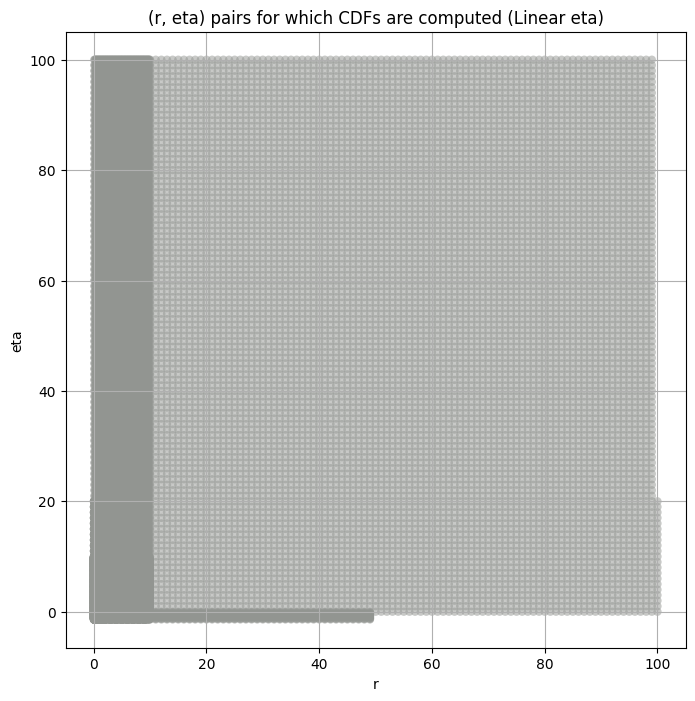

,"(r,eta),cdf",r,eta,cdf,variance,kurtosis,MAD
0,"((0.02, -1.4), <scipy.interpolate._fitpack2.In...",0.02,-1.4,<scipy.interpolate._fitpack2.InterpolatedUniva...,9.618487e+69,1.391529e+25,2.939461e+29
1,"((0.02, -1.3), <scipy.interpolate._fitpack2.In...",0.02,-1.3,<scipy.interpolate._fitpack2.InterpolatedUniva...,3.821735e+74,8.172634e+21,6.491449e+32
2,"((0.02, -1.2), <scipy.interpolate._fitpack2.In...",0.02,-1.2,<scipy.interpolate._fitpack2.InterpolatedUniva...,1.455488e+78,4.131785e+19,1.866882e+35
3,"((0.02, -1.1), <scipy.interpolate._fitpack2.In...",0.02,-1.1,<scipy.interpolate._fitpack2.InterpolatedUniva...,1.406735e+81,6.947275e+17,1.743592e+37
4,"((0.02, -1.0), <scipy.interpolate._fitpack2.In...",0.02,-1.0,<scipy.interpolate._fitpack2.InterpolatedUniva...,5.331443e+83,2.562075e+16,7.822386e+38


In [84]:
#warnings.filterwarnings('ignore', category=RuntimeWarning)

all_cdfs_df = create_kurt_var_ksstat_df(all_cdfs)
coarse_cdf_df = all_cdfs_df[(np.round(all_cdfs_df['r'], 0) == all_cdfs_df['r']) & (np.round(all_cdfs_df['eta'], 0) == all_cdfs_df['eta'])]
var_values_dict = dict()
kurt_values_dict = dict()
master_df = pd.DataFrame(columns=[GROUP]).set_index(GROUP)
temp_cdf = all_cdfs_df
create_scatter_plot(all_cdfs_df);
all_cdfs_df.head()

In [85]:
all_cdfs_df.isna().sum()

(r,eta),cdf       0
r                 0
eta               0
cdf               0
variance          0
kurtosis       1241
MAD               0
dtype: int64

## Bootstrapping the Variance and Kurtosis

In [86]:
n_bootstrap = int(1e5)
bootstrap_size = int(1e4)
ci = 0.99

In [87]:
bootstrap_path = Path(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'))
master_df_var_kurt_path = Path(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'))

if False or not master_df_var_kurt_path.exists():
    for group in GROUPS:
        print(f'{GROUP.capitalize()} {group}')
        obs_var, var_lower, var_upper, var_values_dict[group] = bootstrap_metric(group_data_map[group], 
                                                                                n_bootstrap=n_bootstrap, 
                                                                                bootstrap_size=min(group_data_map[group].size, bootstrap_size), 
                                                                                metric= np.var, 
                                                                                ci=ci)
        obs_kurt, kurt_lower, kurt_upper, kurt_values_dict[group] = bootstrap_metric(group_data_map[group], 
                                                                                    n_bootstrap=n_bootstrap, 
                                                                                    bootstrap_size=min(group_data_map[group].size, bootstrap_size), 
                                                                                    metric= stats.kurtosis, ci=ci)  
        master_df.loc[group, 'obs_var'], master_df.loc[group, 'var_lower'], master_df.loc[group, 'var_upper'] = obs_var, var_lower, var_upper
        master_df.loc[group, 'obs_kurt'], master_df.loc[group, 'kurt_lower'], master_df.loc[group, 'kurt_upper'] = obs_kurt, kurt_lower, kurt_upper
        master_df.loc[group, 'total_samples'] = group_total_samples[group]

    master_df.to_csv(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'))

master_df = pd.read_csv(master_df_var_kurt_path, index_col=GROUP)
var_kurt_df = pd.read_csv(bootstrap_path, index_col=GROUP)
master_df

,obs_var,var_lower,var_upper,obs_kurt,kurt_lower,kurt_upper,total_samples
layer,,,,,,,
2,188570.730000,99638.340000,330262.220000,536.03296,113.304540,760.94360,9000.0
3,42568.312000,23773.760000,71607.330000,488.99530,135.974520,891.27313,36000.0
4,10773.336000,5322.670000,20877.791000,785.24280,131.392270,1768.95340,144000.0
5,1800.434900,923.853000,3624.655000,858.03740,109.913740,2074.88330,576000.0
6,390.887500,183.288650,971.469850,1521.53970,104.035530,3444.52950,2304000.0
7,98.479220,41.024357,351.604030,3306.70500,84.348870,5672.12000,9216000.0
8,33.173733,15.926921,100.374084,2264.61400,78.321760,4638.63770,36864000.0
9,11.252635,4.427865,43.877705,5137.09860,82.329865,6105.37160,147456000.0
10,1.875914,0.615992,10.184826,9775.98100,78.684250,7496.85840,589824000.0


## Initial Grid Search and Hypothesis Test Plots

In [88]:
EXCLUDE_CUTOFFS = [0, 25, 50, 75, 100, 150, 200, 250, 300, 350, 400]
SCALE_CAP = 1e5

In [89]:
augmented_obs_var_df = var_kurt_df[['obs_var']].copy()
augmented_obs_var_df
for val in EXCLUDE_CUTOFFS:
    temp_arr = []
    madd_arr = []
    for group in GROUPS:
        if val != 0:
            temp_arr.append(np.var(group_data_map[group][val:-val]))
        else:
            temp_arr.append(np.var(group_data_map[group]))
        madd_arr.append(np.mean(np.abs(group_data_map[group] - np.mean(group_data_map[group]))))

    augmented_obs_var_df[f"exclude_{val}"] = temp_arr
    augmented_obs_var_df[f"MAD"] = madd_arr
augmented_obs_var_df

,obs_var,exclude_0,MAD,exclude_25,exclude_50,exclude_75,exclude_100,exclude_150,exclude_200,exclude_250,exclude_300,exclude_350,exclude_400
layer,,,,,,,,,,,,,
2,188570.730000,188570.734375,158.803253,53255.480469,45081.785156,40213.917969,36420.285156,30676.792969,26366.972656,23064.148438,20511.724609,18413.591797,16658.740234
3,42568.312000,42568.312500,70.613350,17821.275391,14721.261719,13259.316406,12236.730469,10732.189453,9663.358398,8833.767578,8160.319824,7600.590332,7121.162598
4,10773.336000,10773.335938,31.406000,5597.328125,4464.237793,3925.427979,3574.999512,3107.311768,2816.859863,2605.477295,2443.711670,2310.490234,2194.888672
5,1800.434900,1800.434937,13.657659,967.196716,795.382263,702.730896,642.706543,566.309204,515.472717,477.084412,446.199188,420.567810,398.910187
6,390.887500,390.887512,6.584007,192.203186,158.687836,141.026688,129.362122,114.128799,104.113617,96.796181,91.054344,86.336449,82.370354
7,98.479220,98.479218,3.446948,42.509384,35.698841,32.237232,29.994589,27.104929,25.205553,23.804392,22.697041,21.784376,21.009548
8,33.173733,33.173733,2.206926,16.510288,13.967173,12.692533,11.896943,10.898866,10.253603,9.773006,9.387711,9.064301,8.784658
9,11.252635,11.252635,1.132474,4.574734,3.848108,3.496440,3.280626,3.007298,2.824955,2.686348,2.573658,2.478288,2.395398
10,1.875914,1.875914,0.412296,0.641675,0.543280,0.494285,0.463169,0.422697,0.395412,0.374613,0.357785,0.343469,0.331123


####
Layer  2


100%|██████████| 55966/55966 [00:20<00:00, 2731.38it/s]


Finding Minimum after computing 55966 CDFs
2 0 0.024065082317001163 188570.73


100%|██████████| 55966/55966 [00:18<00:00, 3029.63it/s]


Finding Minimum after computing 55966 CDFs
2 25 0.013681078230516064 53255.48


100%|██████████| 55966/55966 [00:18<00:00, 3033.84it/s]


Finding Minimum after computing 55966 CDFs
2 50 0.014755807792932951 45081.785


100%|██████████| 55966/55966 [00:19<00:00, 2933.20it/s]


Finding Minimum after computing 55966 CDFs
2 75 0.01607633961777244 40213.918


100%|██████████| 55966/55966 [00:18<00:00, 3026.23it/s]


Finding Minimum after computing 55966 CDFs
2 100 0.017662363126010217 36420.285


100%|██████████| 55966/55966 [00:18<00:00, 3038.97it/s]


Finding Minimum after computing 55966 CDFs
2 150 0.02249293698937571 30676.793


100%|██████████| 55966/55966 [00:18<00:00, 3014.78it/s]


Finding Minimum after computing 55966 CDFs
2 200 0.02823791288903854 26366.973


100%|██████████| 55966/55966 [00:18<00:00, 3026.72it/s]


Finding Minimum after computing 55966 CDFs
2 250 0.03385664294315316 23064.148


100%|██████████| 55966/55966 [00:18<00:00, 3036.41it/s]


Finding Minimum after computing 55966 CDFs
2 300 0.03865356555803845 20511.725


100%|██████████| 55966/55966 [00:18<00:00, 2973.07it/s]


Finding Minimum after computing 55966 CDFs
2 350 0.043744923519790646 18413.592


100%|██████████| 55966/55966 [00:18<00:00, 3017.73it/s]


Finding Minimum after computing 55966 CDFs
2 400 0.0492495572306737 16658.74
Number of samples: 9000, Without approximation : 9000.0


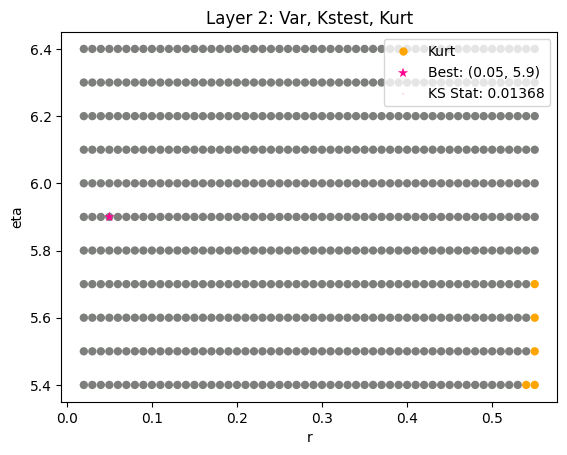

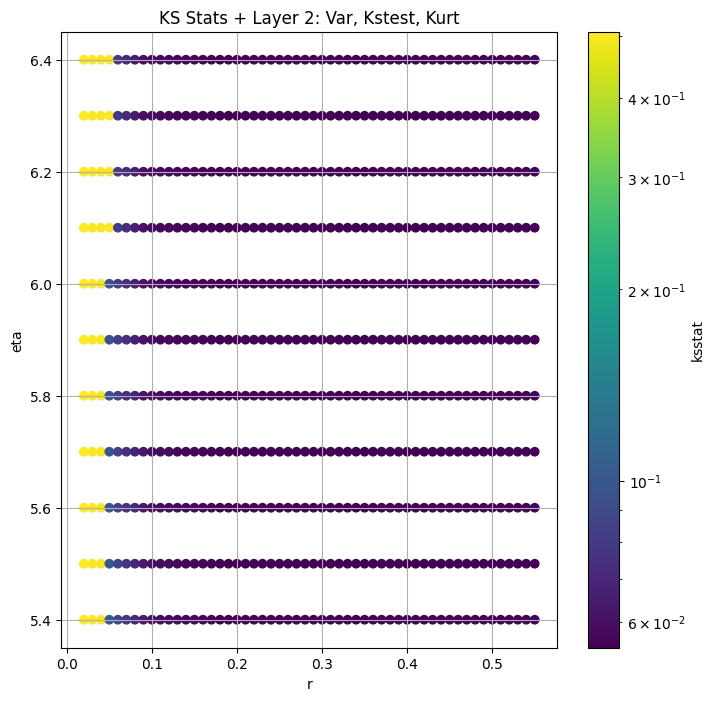

####
Layer  3


100%|██████████| 55966/55966 [01:08<00:00, 820.64it/s]


Finding Minimum after computing 55966 CDFs
3 0 0.02591192062126721 42568.312


100%|██████████| 55966/55966 [01:08<00:00, 818.93it/s]


Finding Minimum after computing 55966 CDFs
3 25 0.01652021173510307 17821.275


100%|██████████| 55966/55966 [01:10<00:00, 795.84it/s]


Finding Minimum after computing 55966 CDFs
3 50 0.014578485853438461 14721.262


100%|██████████| 55966/55966 [01:08<00:00, 813.31it/s]


Finding Minimum after computing 55966 CDFs
3 75 0.01421031822999319 13259.316


100%|██████████| 55966/55966 [01:08<00:00, 818.10it/s]


Finding Minimum after computing 55966 CDFs
3 100 0.013647110935017137 12236.73


100%|██████████| 55966/55966 [01:08<00:00, 813.82it/s]


Finding Minimum after computing 55966 CDFs
3 150 0.013072862728994716 10732.189


100%|██████████| 55966/55966 [01:07<00:00, 831.22it/s]


Finding Minimum after computing 55966 CDFs
3 200 0.012922924743000053 9663.358


100%|██████████| 55966/55966 [01:07<00:00, 828.38it/s]


Finding Minimum after computing 55966 CDFs
3 250 0.013713461651815584 8833.768


100%|██████████| 55966/55966 [01:07<00:00, 829.74it/s]


Finding Minimum after computing 55966 CDFs
3 300 0.014458325320286625 8160.32


100%|██████████| 55966/55966 [01:07<00:00, 830.51it/s]


Finding Minimum after computing 55966 CDFs
3 350 0.01544643112906019 7600.5903


100%|██████████| 55966/55966 [01:11<00:00, 782.38it/s]


Finding Minimum after computing 55966 CDFs
3 400 0.016232754004216088 7121.1626
Number of samples: 36000, Without approximation : 36000.0


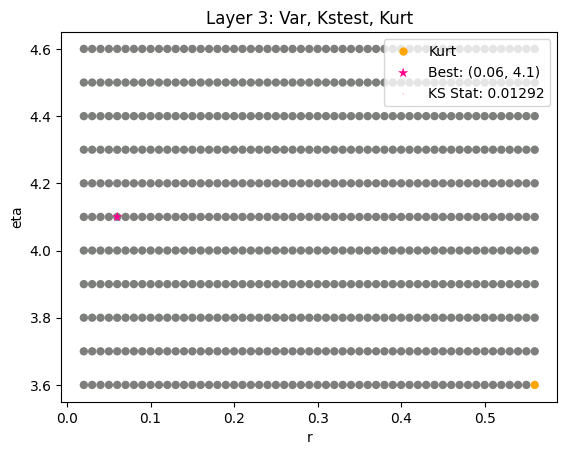

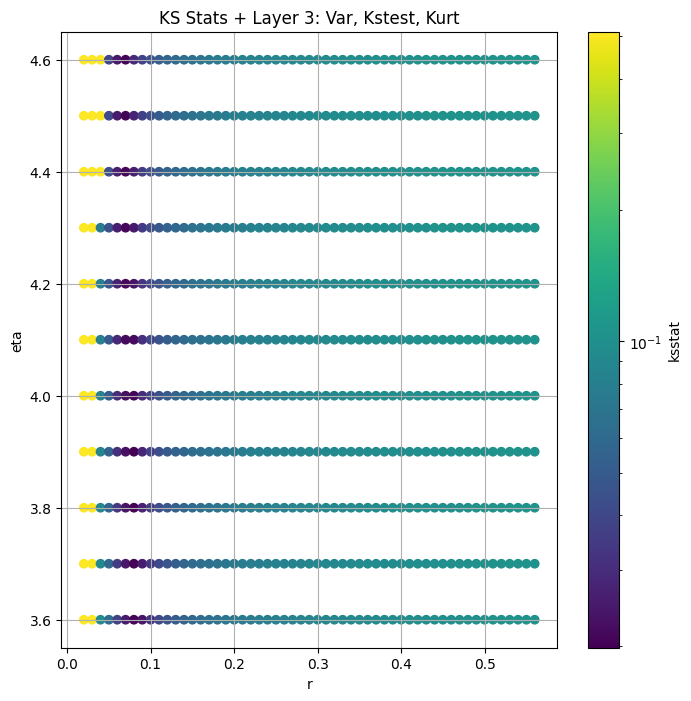

####
Layer  4


100%|██████████| 55966/55966 [03:13<00:00, 289.69it/s]


Finding Minimum after computing 55966 CDFs
4 0 0.02866491212943023 10773.336


100%|██████████| 55966/55966 [03:20<00:00, 279.08it/s]


Finding Minimum after computing 55966 CDFs
4 25 0.018420057163591852 5597.328


100%|██████████| 55966/55966 [03:09<00:00, 295.97it/s]


Finding Minimum after computing 55966 CDFs
4 50 0.015643832730302565 4464.238


100%|██████████| 55966/55966 [03:05<00:00, 302.16it/s]


Finding Minimum after computing 55966 CDFs
4 75 0.01351960969277441 3925.428


100%|██████████| 55966/55966 [03:05<00:00, 301.28it/s]


Finding Minimum after computing 55966 CDFs
4 100 0.01288981316703941 3574.9995


100%|██████████| 55966/55966 [03:05<00:00, 302.50it/s]


Finding Minimum after computing 55966 CDFs
4 150 0.011102429701610128 3107.3118


100%|██████████| 55966/55966 [03:06<00:00, 299.87it/s]


Finding Minimum after computing 55966 CDFs
4 200 0.01010819040291655 2816.8599


100%|██████████| 55966/55966 [03:04<00:00, 302.65it/s]


Finding Minimum after computing 55966 CDFs
4 250 0.008892951231167429 2605.4773


100%|██████████| 55966/55966 [03:04<00:00, 303.36it/s]


Finding Minimum after computing 55966 CDFs
4 300 0.00794988490137552 2443.7117


100%|██████████| 55966/55966 [03:08<00:00, 297.43it/s]


Finding Minimum after computing 55966 CDFs
4 350 0.007640419938646947 2310.4902


100%|██████████| 55966/55966 [03:21<00:00, 278.19it/s]


Finding Minimum after computing 55966 CDFs
4 400 0.007910398876501135 2194.8887
Number of samples: 100000, Without approximation : 144000.0


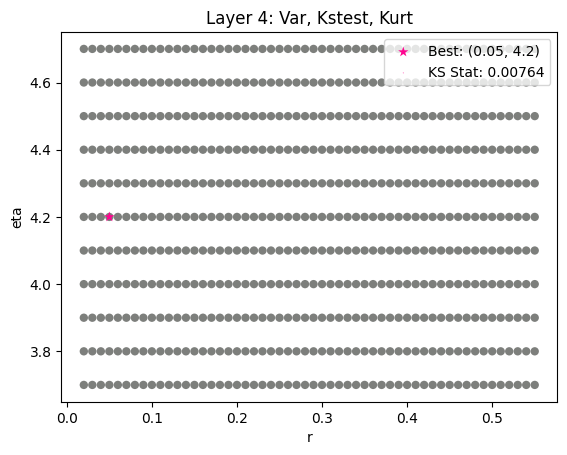

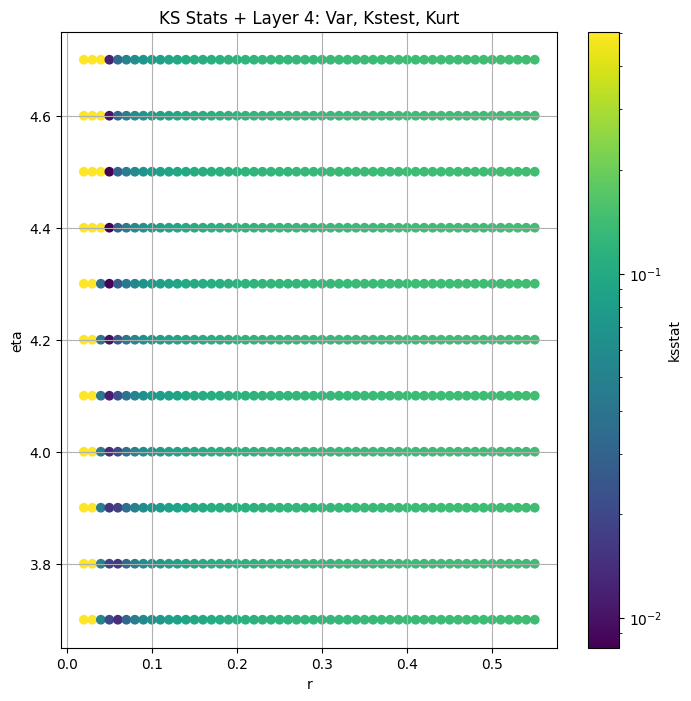

####
Layer  5


100%|██████████| 55966/55966 [03:05<00:00, 301.26it/s]


Finding Minimum after computing 55966 CDFs
5 0 0.025972857078906064 1800.4349


100%|██████████| 55966/55966 [03:07<00:00, 298.58it/s]


Finding Minimum after computing 55966 CDFs
5 25 0.017900217472383614 967.1967


100%|██████████| 55966/55966 [03:11<00:00, 291.71it/s]


Finding Minimum after computing 55966 CDFs
5 50 0.014691047530205267 795.38226


100%|██████████| 55966/55966 [03:06<00:00, 300.05it/s]


Finding Minimum after computing 55966 CDFs
5 75 0.0129973814192825 702.7309


100%|██████████| 55966/55966 [03:07<00:00, 298.67it/s]


Finding Minimum after computing 55966 CDFs
5 100 0.01097952806904394 642.70654


100%|██████████| 55966/55966 [03:05<00:00, 301.96it/s]


Finding Minimum after computing 55966 CDFs
5 150 0.009289516503620532 566.3092


100%|██████████| 55966/55966 [03:07<00:00, 298.26it/s]


Finding Minimum after computing 55966 CDFs
5 200 0.007486586538149015 515.4727


100%|██████████| 55966/55966 [03:06<00:00, 300.52it/s]


Finding Minimum after computing 55966 CDFs
5 250 0.006595878564900209 477.0844


100%|██████████| 55966/55966 [03:14<00:00, 287.57it/s]


Finding Minimum after computing 55966 CDFs
5 300 0.005897046840239284 446.1992


100%|██████████| 55966/55966 [03:12<00:00, 291.36it/s]


Finding Minimum after computing 55966 CDFs
5 350 0.006428706232798009 420.5678


100%|██████████| 55966/55966 [03:14<00:00, 288.17it/s]


Finding Minimum after computing 55966 CDFs
5 400 0.0070086059392518996 398.9102
Number of samples: 100000, Without approximation : 576000.0


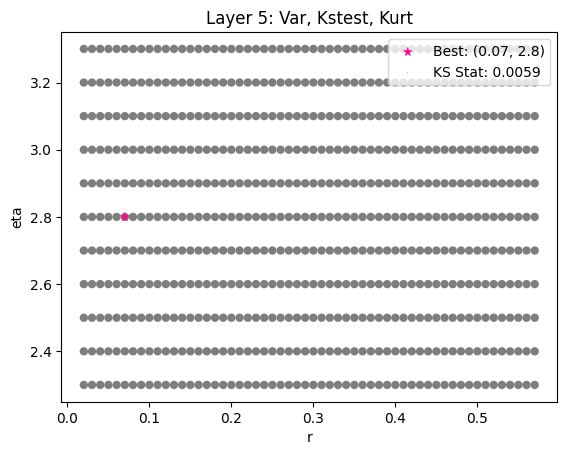

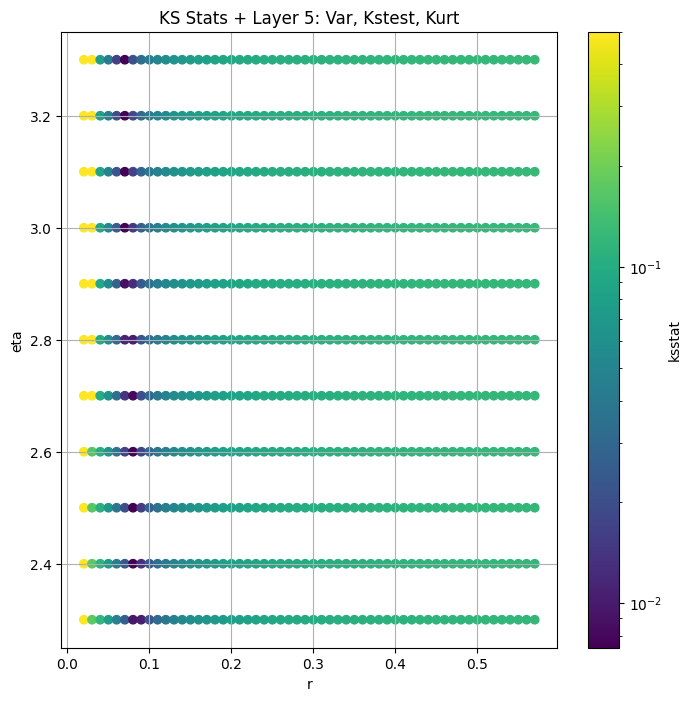

####
Layer  6


100%|██████████| 55966/55966 [03:11<00:00, 292.31it/s]


Finding Minimum after computing 55966 CDFs
6 0 0.027878517092720864 390.8875


100%|██████████| 55966/55966 [03:07<00:00, 297.83it/s]


Finding Minimum after computing 55966 CDFs
6 25 0.017044158528219236 192.20319


100%|██████████| 55966/55966 [03:08<00:00, 297.59it/s]


Finding Minimum after computing 55966 CDFs
6 50 0.013004379158550822 158.68784


100%|██████████| 55966/55966 [03:04<00:00, 302.86it/s]


Finding Minimum after computing 55966 CDFs
6 75 0.010609584364940167 141.02669


100%|██████████| 55966/55966 [03:05<00:00, 302.11it/s]


Finding Minimum after computing 55966 CDFs
6 100 0.009393652550666126 129.36212


100%|██████████| 55966/55966 [03:03<00:00, 304.24it/s]


Finding Minimum after computing 55966 CDFs
6 150 0.006385794526875321 114.1288


100%|██████████| 55966/55966 [03:05<00:00, 302.29it/s]


Finding Minimum after computing 55966 CDFs
6 200 0.004336922426086451 104.11362


100%|██████████| 55966/55966 [03:04<00:00, 303.10it/s]


Finding Minimum after computing 55966 CDFs
6 250 0.004093537406921088 96.79618


100%|██████████| 55966/55966 [03:04<00:00, 303.97it/s]


Finding Minimum after computing 55966 CDFs
6 300 0.004706824930265863 91.054344


100%|██████████| 55966/55966 [03:02<00:00, 306.16it/s]


Finding Minimum after computing 55966 CDFs
6 350 0.005317859572445016 86.33645


100%|██████████| 55966/55966 [03:03<00:00, 305.49it/s]


Finding Minimum after computing 55966 CDFs
6 400 0.0059272386603888005 82.37035
Number of samples: 100000, Without approximation : 2304000.0


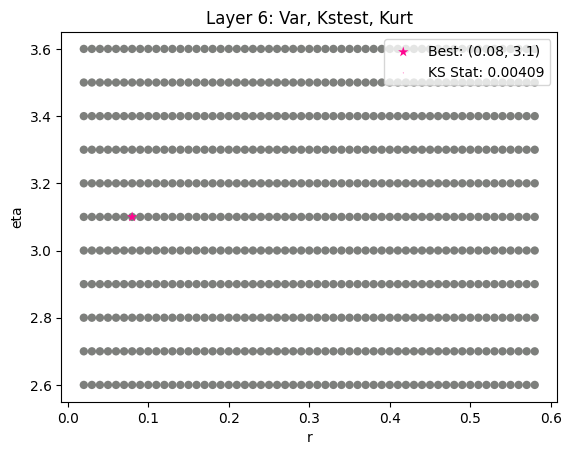

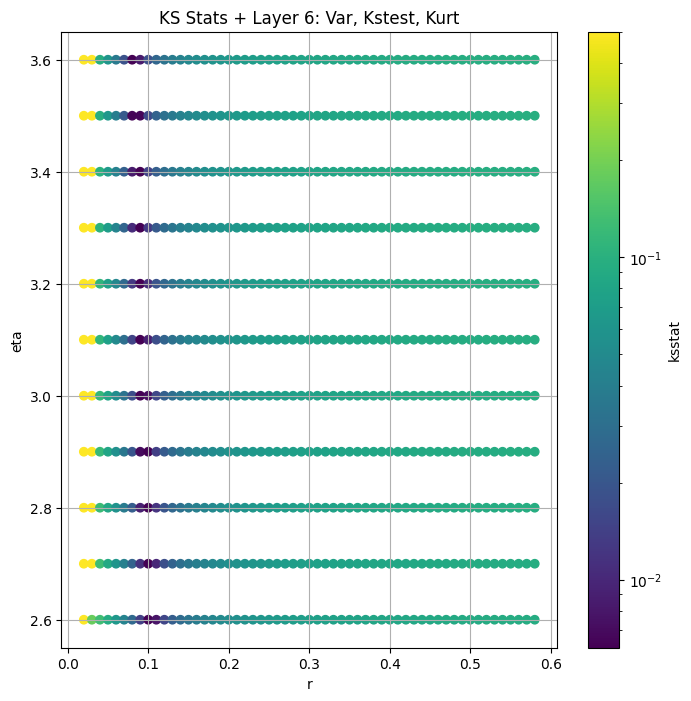

####
Layer  7


100%|██████████| 55966/55966 [03:03<00:00, 305.65it/s]


Finding Minimum after computing 55966 CDFs
7 0 0.028445411542838972 98.47922


100%|██████████| 55966/55966 [03:02<00:00, 305.88it/s]


Finding Minimum after computing 55966 CDFs
7 25 0.012966509118390812 42.509384


100%|██████████| 55966/55966 [03:04<00:00, 303.79it/s]


Finding Minimum after computing 55966 CDFs
7 50 0.008997478919192448 35.69884


100%|██████████| 55966/55966 [03:03<00:00, 305.49it/s]


Finding Minimum after computing 55966 CDFs
7 75 0.006750004049166702 32.237232


100%|██████████| 55966/55966 [03:03<00:00, 305.74it/s]


Finding Minimum after computing 55966 CDFs
7 100 0.0052897416112648865 29.994589


100%|██████████| 55966/55966 [03:03<00:00, 305.71it/s]


Finding Minimum after computing 55966 CDFs
7 150 0.003950983671614727 27.104929


100%|██████████| 55966/55966 [03:03<00:00, 304.70it/s]


Finding Minimum after computing 55966 CDFs
7 200 0.0038122530809918675 25.205553


100%|██████████| 55966/55966 [03:04<00:00, 303.65it/s]


Finding Minimum after computing 55966 CDFs
7 250 0.0038594083067428064 23.804392


100%|██████████| 55966/55966 [03:04<00:00, 303.74it/s]


Finding Minimum after computing 55966 CDFs
7 300 0.004331850572723783 22.69704


100%|██████████| 55966/55966 [03:05<00:00, 302.12it/s]


Finding Minimum after computing 55966 CDFs
7 350 0.004953933906316932 21.784376


100%|██████████| 55966/55966 [03:04<00:00, 303.51it/s]


Finding Minimum after computing 55966 CDFs
7 400 0.005562891846252471 21.009548
Number of samples: 100000, Without approximation : 9216000.0


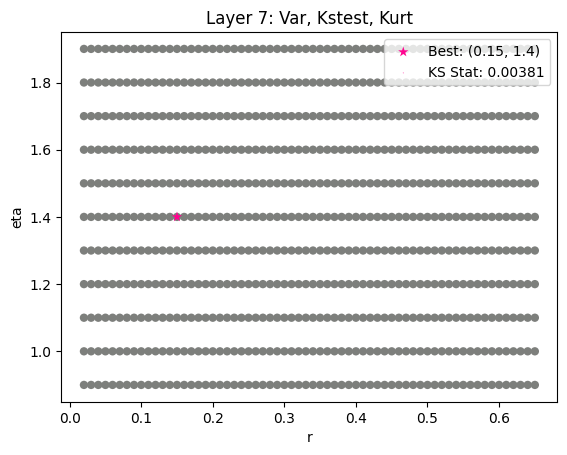

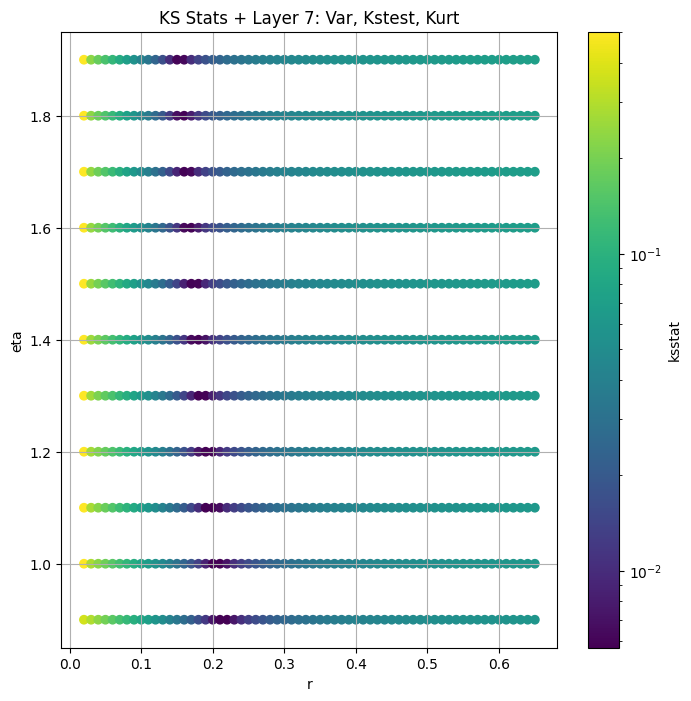

####
Layer  8


100%|██████████| 55966/55966 [03:03<00:00, 304.83it/s]


Finding Minimum after computing 55966 CDFs
8 0 0.021400611142691706 33.173733


100%|██████████| 55966/55966 [03:03<00:00, 304.62it/s]


Finding Minimum after computing 55966 CDFs
8 25 0.008631604680845895 16.510288


100%|██████████| 55966/55966 [03:04<00:00, 303.29it/s]


Finding Minimum after computing 55966 CDFs
8 50 0.004431160919522538 13.967173


100%|██████████| 55966/55966 [03:05<00:00, 301.22it/s]


Finding Minimum after computing 55966 CDFs
8 75 0.003349999999999853 12.692533


100%|██████████| 55966/55966 [03:06<00:00, 300.40it/s]


Finding Minimum after computing 55966 CDFs
8 100 0.0033499999999965224 11.896943


100%|██████████| 55966/55966 [03:08<00:00, 297.45it/s]


Finding Minimum after computing 55966 CDFs
8 150 0.0033499999999968555 10.898866


100%|██████████| 55966/55966 [03:07<00:00, 297.81it/s]


Finding Minimum after computing 55966 CDFs
8 200 0.0033499999999965224 10.253603


100%|██████████| 55966/55966 [03:05<00:00, 302.26it/s]


Finding Minimum after computing 55966 CDFs
8 250 0.0035137196063135256 9.773006


100%|██████████| 55966/55966 [03:05<00:00, 302.25it/s]


Finding Minimum after computing 55966 CDFs
8 300 0.004225855126023026 9.387711


100%|██████████| 55966/55966 [03:05<00:00, 302.27it/s]


Finding Minimum after computing 55966 CDFs
8 350 0.004921838964782044 9.064301


100%|██████████| 55966/55966 [03:05<00:00, 302.27it/s]


Finding Minimum after computing 55966 CDFs
8 400 0.005587456702228821 8.784658
Number of samples: 100000, Without approximation : 36864000.0


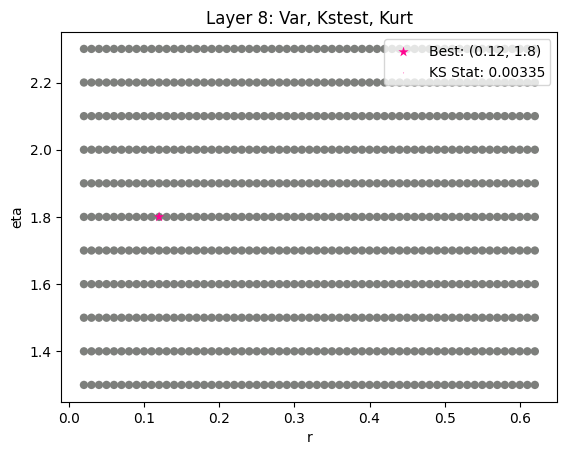

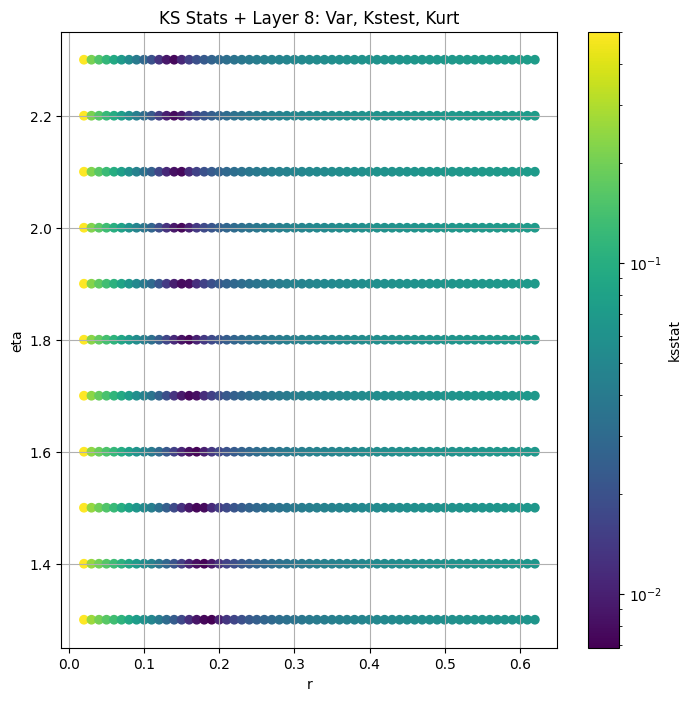

####
Layer  9


100%|██████████| 55966/55966 [03:03<00:00, 304.24it/s]


Finding Minimum after computing 55966 CDFs
9 0 0.024747447998198113 11.252635


100%|██████████| 55966/55966 [03:04<00:00, 303.73it/s]


Finding Minimum after computing 55966 CDFs
9 25 0.009136994247288865 4.5747337


100%|██████████| 55966/55966 [03:03<00:00, 305.38it/s]


Finding Minimum after computing 55966 CDFs
9 50 0.005950000000000011 3.8481076


100%|██████████| 55966/55966 [03:05<00:00, 302.45it/s]


Finding Minimum after computing 55966 CDFs
9 75 0.005949999999996014 3.4964397


100%|██████████| 55966/55966 [03:04<00:00, 303.05it/s]


Finding Minimum after computing 55966 CDFs
9 100 0.005949999999982691 3.2806263


100%|██████████| 55966/55966 [03:05<00:00, 302.27it/s]


Finding Minimum after computing 55966 CDFs
9 150 0.005949999999982469 3.0072985


100%|██████████| 55966/55966 [03:05<00:00, 302.25it/s]


Finding Minimum after computing 55966 CDFs
9 200 0.005949999999984024 2.8249547


100%|██████████| 55966/55966 [03:04<00:00, 303.03it/s]


Finding Minimum after computing 55966 CDFs
9 250 0.005949999999985134 2.686348


100%|██████████| 55966/55966 [03:04<00:00, 303.49it/s]


Finding Minimum after computing 55966 CDFs
9 300 0.005949999999986244 2.5736582


100%|██████████| 55966/55966 [03:04<00:00, 303.78it/s]


Finding Minimum after computing 55966 CDFs
9 350 0.005949999999990019 2.4782884


100%|██████████| 55966/55966 [03:04<00:00, 302.54it/s]


Finding Minimum after computing 55966 CDFs
9 400 0.005949999999989797 2.3953981
Number of samples: 100000, Without approximation : 147456000.0


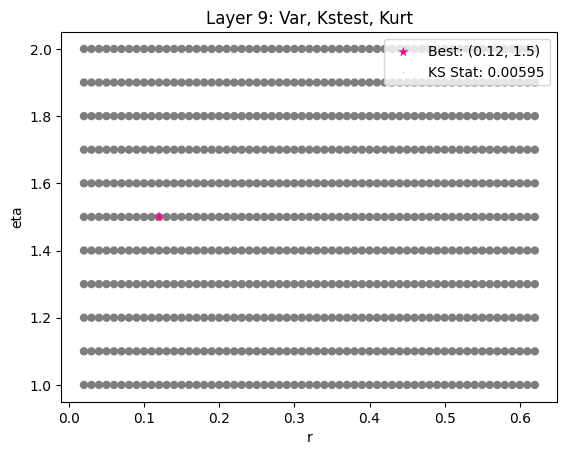

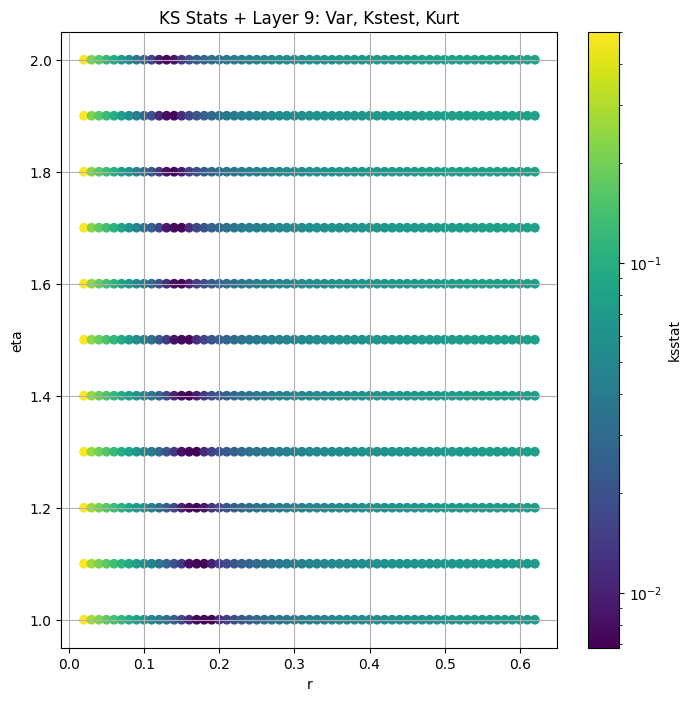

####
Layer  10


100%|██████████| 55966/55966 [03:04<00:00, 303.39it/s]


Finding Minimum after computing 55966 CDFs
10 0 0.02924344561515088 1.8759142


100%|██████████| 55966/55966 [03:03<00:00, 304.87it/s]


Finding Minimum after computing 55966 CDFs
10 25 0.026099999999986523 0.6416747


100%|██████████| 55966/55966 [03:07<00:00, 298.41it/s]


Finding Minimum after computing 55966 CDFs
10 50 0.02609999999998447 0.5432802


100%|██████████| 55966/55966 [03:05<00:00, 301.62it/s]


Finding Minimum after computing 55966 CDFs
10 75 0.026099999999982526 0.4942845


100%|██████████| 55966/55966 [03:08<00:00, 296.46it/s]


Finding Minimum after computing 55966 CDFs
10 100 0.026099999999981527 0.4631687


100%|██████████| 55966/55966 [03:04<00:00, 303.05it/s]


Finding Minimum after computing 55966 CDFs
10 150 0.026099999999979917 0.42269677


100%|██████████| 55966/55966 [03:04<00:00, 303.13it/s]


Finding Minimum after computing 55966 CDFs
10 200 0.02609999999998014 0.39541236


100%|██████████| 55966/55966 [03:04<00:00, 303.61it/s]


Finding Minimum after computing 55966 CDFs
10 250 0.026099999999978696 0.3746135


100%|██████████| 55966/55966 [03:04<00:00, 303.58it/s]


Finding Minimum after computing 55966 CDFs
10 300 0.026099999999977863 0.35778508


100%|██████████| 55966/55966 [03:04<00:00, 303.76it/s]


Finding Minimum after computing 55966 CDFs
10 350 0.02609999999997764 0.34346884


100%|██████████| 55966/55966 [03:04<00:00, 303.60it/s]


Finding Minimum after computing 55966 CDFs
10 400 0.026099999999977697 0.33112258
Number of samples: 100000, Without approximation : 589824000.0


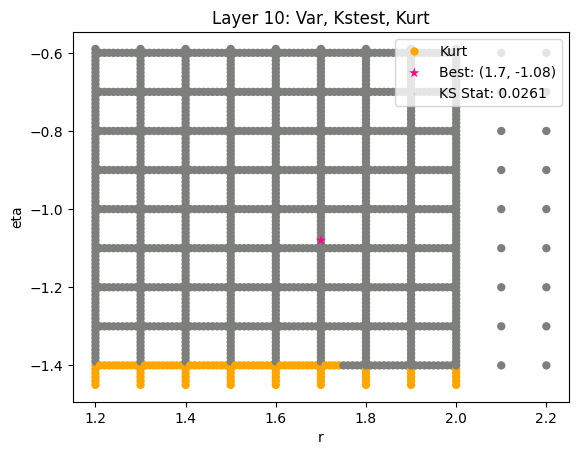

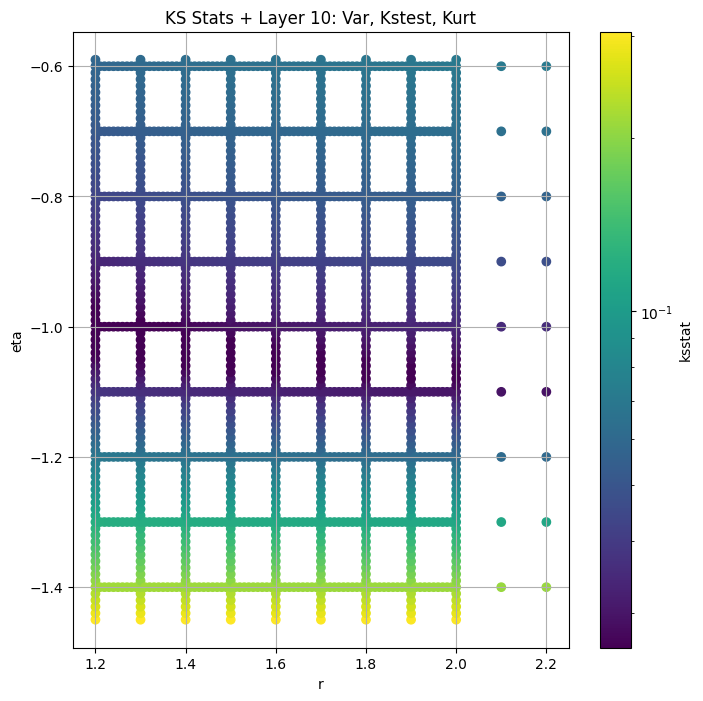

,obs_var,var_lower,var_upper,obs_kurt,kurt_lower,kurt_upper,total_samples,kstest_stat_initial,initial_r,initial_eta,initial_scale,best_exclude_cutoff,kstest_stat_cutoff_0.05
layer,,,,,,,,,,,,,
2,188570.730000,99638.340000,330262.220000,536.03296,113.304540,760.94360,9000.0,0.013681,0.05,5.90,6.117604e-40,25.0,0.014297
3,42568.312000,23773.760000,71607.330000,488.99530,135.974520,891.27313,36000.0,0.012923,0.06,4.10,3.767124e-30,200.0,0.007153
4,10773.336000,5322.670000,20877.791000,785.24280,131.392270,1768.95340,144000.0,0.007640,0.05,4.20,3.466181e-39,350.0,0.003578
5,1800.434900,923.853000,3624.655000,858.03740,109.913740,2074.88330,576000.0,0.005897,0.07,2.80,2.990083e-24,300.0,0.001789
6,390.887500,183.288650,971.469850,1521.53970,104.035530,3444.52950,2304000.0,0.004094,0.08,3.10,3.029738e-21,250.0,0.000895
7,98.479220,41.024357,351.604030,3306.70500,84.348870,5672.12000,9216000.0,0.003812,0.15,1.40,2.759916e-08,200.0,0.000447
8,33.173733,15.926921,100.374084,2264.61400,78.321760,4638.63770,36864000.0,0.003350,0.12,1.80,4.352079e-12,100.0,0.000224
9,11.252635,4.427865,43.877705,5137.09860,82.329865,6105.37160,147456000.0,0.005950,0.12,1.50,2.218216e-12,150.0,0.000112
10,1.875914,0.615992,10.184826,9775.98100,78.684250,7496.85840,589824000.0,0.026100,1.70,-1.08,1.119040e+00,350.0,0.000056


In [92]:
master_df_combo_path = Path(os.path.join(CWD, "CSVs", "master_df_combo.csv"))
rEtaKsstats_dict = dict()

if RERUN or not master_df_combo_path.exists():
    sorted_params = sorted(all_cdfs)
    group_cdf_df_dict = dict()
    ksstats_dict = dict()

    for i, group in enumerate(GROUPS):
        print(f"####\n{GROUP.capitalize()} ", group)
        sample = group_data_map[group]
        group_cdf_df = all_cdfs_df.copy()
        master_df.loc[group, 'kstest_stat_initial'] = 1

        for exclude_cutoff in EXCLUDE_CUTOFFS:
            if exclude_cutoff != 0:
                augmented_obs_var = np.var(group_data_map[group][exclude_cutoff:-exclude_cutoff])
            else:
                augmented_obs_var = np.var(group_data_map[group])
                #samp_MAD = np.mean(np.abs(group_data_map[group] - np.mean((group_data_map[group]))))

            group_cdf_df['scale'] = np.clip((augmented_obs_var / group_cdf_df['variance']), 0,  SCALE_CAP)
            ksstats, initial_param, min_stat = gridsearch(sample, all_cdfs, debug=True, scales=group_cdf_df['scale'])
            group_cdf_df[f'ksstat_{exclude_cutoff}'] = ksstats
            print(group, exclude_cutoff, min_stat, augmented_obs_var)
            if min_stat < master_df.loc[group, 'kstest_stat_initial']:
                inital_min_stat = min_stat
                inital_best_param = initial_param
                master_df.loc[group, 'kstest_stat_initial'] = min_stat
                initial_scale = group_cdf_df.loc[(group_cdf_df["r"] ==  initial_param[0]) & (group_cdf_df["eta"] ==  initial_param[1])]["scale"].iloc[0]
                master_df.loc[group, 'initial_r'], master_df.loc[group, 'initial_eta'] = initial_param
                master_df.loc[group, 'initial_scale'] = initial_scale
                master_df.loc[group, 'best_exclude_cutoff'] = exclude_cutoff
            
        
        print(f"Number of samples: {sample.size}, Without approximation : {master_df.loc[group, 'total_samples']}")
        
        cutoff = stats.kstwo(n=master_df.loc[group, 'total_samples']).isf(0.05)
        master_df.loc[group, 'kstest_stat_cutoff_0.05'] = cutoff

        group_cdf_df['variance'] = group_cdf_df['variance'] * group_cdf_df['scale']
        group_cdf_df['kurtosis'] = group_cdf_df['kurtosis'] * group_cdf_df['scale']

        group_cdf_df = add_tests_to_df(cdfs_df = group_cdf_df, group = group, var_kurt_df = master_df, ksstats = ksstats)
        group_cdf_df_dict[group] = group_cdf_df

        temp_df = group_cdf_df_dict[group].sort_values(['r', 'eta'])
        rEtaKsstats_dict[group] = [temp_df['r'], temp_df['eta'], temp_df['ksstat']] + [temp_df[f'ksstat_{exclude_cutoff}'] for exclude_cutoff in EXCLUDE_CUTOFFS]

        cols = ['pass_var', 'pass_kstest', 'pass_kurt']

        fig = combo_test_plot(group_cdf_df_dict[group], cols, 
                            plot_name=f"{GROUP.capitalize()} {group}: {', '.join([col[5:].capitalize() for col in cols])}", 
                            target_var = None,
                            best_param = inital_best_param,
                            best_ksstat=inital_min_stat
                            )
        
        fig.figure.savefig(os.path.join(CWD, "plots", f"full_grid_search_combo_plot_layer{group}.jpg"), bbox_inches = 'tight', dpi=300)

        # Optional: 
        # Create plots of bootstrapped variance and kurtosis for varying confidence intervals
        # fig_var = create_ci_scatter_plot(group_cdf_df_dict[group], var_values_dict, metric='variance', group=group)
        # fig_kurt = create_ci_scatter_plot(group_cdf_df_dict[group], kurt_values_dict, metric='kurtosis', group=group)

        # fig_var.savefig(os.path.join(CWD, "plots", f"ci_scatter_variance_{GROUP}_{group}_bootstrap{n_bootstrap}.jpg"), bbox_inches='tight')
        # plt.close(fig_var)
        # fig_kurt.savefig(os.path.join(CWD, "plots", f"ci_scatter_variance_{GROUP}_{group}_bootstrap{n_bootstrap}.jpg"), bbox_inches='tight')
        # plt.close(fig_kurt)

    master_df.to_csv(os.path.join(CWD, "CSVs", "master_df_combo.csv"))
    pd.to_pickle(rEtaKsstats_dict, os.path.join(CWD, "cache", 'rEtaKsstats_dict.pickle'))

master_df = pd.read_csv(master_df_combo_path, index_col=GROUP)
master_df

### Search over $\eta=0$

In [ ]:
master_df_eta0_path = Path(os.path.join(CWD, "CSVs", "master_df_eta0.csv"))

if RERUN or not master_df_eta0_path.exists():
    best_params_eta0 = []
    for i, group in enumerate(GROUPS):
        if master_df.loc[group, 'initial_eta'] != 0:
            sample = group_data_map[group]
            group_cdf = all_cdfs_df[all_cdfs_df['eta'] == 0]
            cdfs_dict = {i[0]:i[1] for i in group_cdf['(r,eta),cdf']}
            ksstats, best_param_eta0, kstest_stat_eta0 = gridsearch(sample, cdfs_dict, debug=True, scales=group_cdf_df['scale'])
            best_scale_eta0 = group_cdf_df.loc[(group_cdf_df["r"] ==  best_param_eta0[0]) & (group_cdf_df["eta"] ==  best_param_eta0[1])]["scale"].iloc[0]
            master_df.loc[group, 'best_r_eta0'] = best_param_eta0[0]
            master_df.loc[group, 'best_scale_eta0'] = best_scale_eta0
            master_df.loc[group, 'kstest_stat_eta0'] = kstest_stat_eta0
        else:
            master_df.loc[group, 'kstest_stat_eta0'] = master_df.loc[group, 'kstest_stat_initial']
            master_df.loc[group, 'best_r_eta0'] = master_df.loc[group, 'initial_r']
            master_df.loc[group, 'best_scale_eta0'] = master_df.loc[group, 'initial_scale']
    master_df.to_csv(os.path.join(CWD, "CSVs", "master_df_eta0.csv"))

master_df = pd.read_csv(master_df_eta0_path, index_col=GROUP)
master_df

## Optimization

In [ ]:
def simple_add_cdfs(r_range, eta_range, dir, folder_name = '', n_samples = 500, tail_bound = 0.01, tail_percent = 0.1, enforce_assert=True, return_assert = False, debug=False):

    if folder_name == '':
        folder_name = f'r{round_to_sigfigs(min(r_range))}to{round_to_sigfigs(max(r_range))}_eta{round_to_sigfigs(min(eta_range))}to{round_to_sigfigs(max(eta_range))}'

    FOLDER_PATH = os.path.join(dir, folder_name)

    if os.path.isdir(FOLDER_PATH):
        cdfs_completed = combine_pickles(FOLDER_PATH)
        if debug:
            print("CDFs completed:", len(cdfs_completed))
    else:
        Path(os.path.join(os.getcwd(), FOLDER_PATH)).mkdir()
        cdfs_completed = dict()

    n = len(r_range)*len(eta_range)
    finished = len(cdfs_completed)
    cnt = len(cdfs_completed)
    for r in r_range:
        r_cdf = dict()
        r = round_to_sigfigs(r)
        for eta in eta_range:
            eta = round_to_sigfigs(eta)
            if ((r, eta) in cdfs_completed) and cdfs_completed[(r, eta)]:
                continue
            cnt += 1
            if debug:
                print(f'{(r, eta)}, {cnt} of {n + finished}')
            if cnt % 50 == 0:
                print(f'{(r, eta)}, {cnt} of {n + finished}')

            computed_cdf = compute_prior_cdf(r = r, eta = eta, method = 'gamma_cdf', n_samples = n_samples, tail_percent = tail_percent, tail_bound = tail_bound, 
                                             enforce_assert=enforce_assert, return_assert=return_assert, debug=debug)
            r_cdf[(r, eta)] = computed_cdf
        if r_cdf:
            sorted_r_cdf = [i[1] for i in sorted(r_cdf)]
            min_eta, max_eta = round_to_sigfigs(min(sorted_r_cdf), 6), round_to_sigfigs(max(sorted_r_cdf), 6)
            pkl_path = os.path.join(FOLDER_PATH, f'r{r}_eta{min_eta}to{max_eta}.pickle')
            pd.to_pickle(r_cdf, pkl_path)
        else:
            if debug:
                print(f"Skipped {r} entirely")

    if debug:
        print(f'You can find the CDFs here: {os.path.join(os.getcwd(), FOLDER_PATH)}')

In [ ]:
master_df_optimized_path = Path(os.path.join(CWD, "CSVs", 'master_df_optimized.csv'))
rEtaKsstats_dict_path = Path(os.path.join(CWD, "cache", "rEtaKsstats_dict.pickle"))


SKIP_OPTIMIZE_STEP = False
NUM_ITERS = dict(zip(GROUPS, [1]*len(GROUPS)))
NUM_SAMPLES_OPTIMIZE = 2000

if RERUN or not master_df_optimized_path.exists():
    rEtaKsstats_dict = dict()

    if SKIP_OPTIMIZE_STEP:
        master_df['kstest_stat_best'] = master_df['kstest_stat_initial']
        master_df[f'best_r'] = master_df['initial_r']
        master_df[f'best_eta'] = master_df['initial_eta']
    else:
        for group in GROUPS: 
            print(f"{GROUP.capitalize()} {group}")
            sample = group_data_map[group]
            initial_r, initial_eta = master_df.loc[group, 'initial_r'], master_df.loc[group, f'initial_eta']
            r_granularity = 10
            eta_granularity = 10
            for i in range(0, -5, -1):
                if tuple([round_to_sigfigs(initial_r + 10.**i, 8), initial_eta]) in all_cdfs:
                    r_granularity = 10.**i
                if tuple([initial_r, round_to_sigfigs(initial_eta + 10.**i, 8)]) in all_cdfs:
                    
                    eta_granularity = 10.**i

            for d in range(1, NUM_ITERS[group] + 1):
                if d == 1:
                    initial_r, initial_eta = master_df.loc[group, 'initial_r'], master_df.loc[group, f'initial_eta']
                else:
                    initial_r, initial_eta = master_df.loc[group, f'iter{d - 1}_r'], master_df.loc[group, f'iter{d - 1}_eta']
                r_granularity = r_granularity * 10.0**(-d+1) 
                eta_granularity = eta_granularity * 10.0**(-d+1) 

                r_range = [round_to_sigfigs(x) for x in np.arange(initial_r - r_granularity, initial_r + r_granularity, r_granularity/10)]
                eta_range = [round_to_sigfigs(x) for x in np.arange(initial_eta - eta_granularity, initial_eta + eta_granularity, eta_granularity/10)]
                simple_add_cdfs(r_range, eta_range, dir = os.path.join(CWD, "groupCDFs"), folder_name=f'{GROUP}{group}', n_samples = NUM_SAMPLES_OPTIMIZE, debug=False, tail_bound=1e-5)
                cdfs_dict = combine_pickles(os.path.join(CWD, "groupCDFs", f'{GROUP}{group}'))
                

                temp_df = create_kurt_var_ksstat_df(cdfs_dict)
                temp_df['scale'] = np.clip(master_df.loc[group,'obs_var'] / temp_df['variance'], 0, 1e5)
                temp_df['variance'] = temp_df['variance'] * temp_df['scale']
                temp_df['kurtosis'] = temp_df['kurtosis'] * temp_df['scale']
                ksstats, best_param, kstest_stat = gridsearch(sample, cdfs_dict, debug=True, scales=temp_df['scale'])
                temp_df = add_tests_to_df(cdfs_df=temp_df, group=group, var_kurt_df=master_df, ksstats=ksstats)
                
                group_cdf_df_dict[group] = pd.concat([group_cdf_df_dict[group], temp_df])
                master_df.loc[group, 'best_r'], master_df.loc[group, f'best_eta'] = best_param[0], best_param[1]
                best_scale = temp_df.loc[(temp_df["r"] ==  best_param[0])&(temp_df["eta"] ==  best_param[1])]["scale"].iloc[0]
                master_df.loc[group, 'best_scale'] = best_scale
                master_df.loc[group, 'kstest_stat_best'] = kstest_stat
                master_df.loc[group, f'iter{d}_r'], master_df.loc[group, f'iter{d}_eta'] = best_param[0], best_param[1]
                master_df.loc[group, f'kstest_stat_iter{d}'] = kstest_stat
                
                print(f"Iter {d} {GROUP} {group} best parameters: {best_param, master_df.loc[group, f'kstest_stat_iter{d}']}")

            temp_df = group_cdf_df_dict[group].sort_values(['r', 'eta'])
            rEtaKsstats_dict[group] = [temp_df['r'], temp_df['eta'], temp_df['ksstat']]

            eps = 0.1
            filtered_df = temp_df[(temp_df['r'] > master_df.loc[group, 'initial_r'] - eps) & 
                            (temp_df['r'] < master_df.loc[group, 'initial_r'] + eps) &
                            (temp_df['eta'] > master_df.loc[group, 'initial_eta'] - eps) &
                            (temp_df['eta'] < master_df.loc[group, 'initial_eta'] + eps)]
            cols = ['pass_var', 'pass_kstest', 'pass_kurt']
            fig = combo_test_plot(filtered_df, cols, 
                                plot_name=f"{GROUP.capitalize()} {group} zoomed in: {', '.join([col[5:].capitalize() for col in cols])}",
                                best_param=(master_df.loc[group, 'best_r'], master_df.loc[group, f'best_eta']),
                                best_ksstat=kstest_stat)
            fig.figure.savefig(os.path.join(CWD, "plots", f"optimized_full_grid_search_combo_plot_layer{group}.jpg"), bbox_inches = 'tight', dpi=300)
            
    master_df['n_pval_0.05'] = master_df.apply(lambda row : find_n_fixed_pval_stat(row.loc['kstest_stat_best'], row.loc['total_samples']), axis = 1)    
    master_df[['total_samples', 'initial_r', 'initial_eta', 'kstest_stat_initial', 'best_r', 'best_eta', 'best_scale', 'kstest_stat_best', 'n_pval_0.05']].to_csv(os.path.join(CWD, "CSVs", 'optimized_params.csv'))
    master_df.to_csv(os.path.join(CWD, "CSVs", 'master_df_optimized.csv'))
    pd.to_pickle(rEtaKsstats_dict, os.path.join(CWD, "cache", 'rEtaKsstats_dict.pickle'))

master_df = pd.read_csv(master_df_optimized_path, index_col = GROUP)
master_df

## Comparing Empirical and Computed CDF/PDF

In [ ]:
for group in GROUPS:
    group_info = master_df.loc[group]
    best_r = group_info['best_r']
    best_eta = group_info['best_eta']
    best_scale = group_info['best_scale']
    fig = visualize_cdf_pdf(sample = group_data_map[group], 
                    params = (best_r, best_eta, best_scale), 
                    log_scale = True,
                    group = group)
    fig.savefig(os.path.join(CWD, "plots", f'compare_cdf_pdf_layer_{group}.jpg'), bbox_inches = 'tight', dpi = 600)

## Comparing with Gaussian and Laplace Priors

In [ ]:
def generate_func(sample, distro, *args, n_samples=200):
    if distro == 'gaussian' or distro == 'normal':
        def var_func(var):
            cdf = scipy.stats.norm(scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 'laplace':
        def var_func(var):
            cdf = scipy.stats.laplace(scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 't':
        def var_func(var):
            cdf = scipy.stats.t(df=2, scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 'prior_r':
        eta = args[0]
        def r_func(r):
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples)
            return compute_ksstat(sample, cdf)
        return r_func
    elif distro == 'prior_eta':
        r = args[0]
        def eta_func(eta):
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples)
            return compute_ksstat(sample, cdf)
        return eta_func
    elif distro == 'prior':
        def r_eta_func(params):
            r = params[0]
            eta = params[1]
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples, debug=False)
            return compute_ksstat(sample, cdf)
        return r_eta_func
    elif distro == 'prior_with_scale':
        def r_eta_scale_func(params):
            r = params[0]
            eta = params[1]
            scale = params[2]
            print(r, eta, scale)
            cdf = compute_prior_cdf(r = r, eta = eta, n_samples=n_samples, debug=False)
            return compute_ksstat(sample/ np.sqrt(scale), cdf)
        return r_eta_scale_func

    print("Please enter a valid argument for `distro`: 'gaussian', 'laplace', 'prior_r', 'prior_eta', 'prior','prior_with_scale', 't'")

In [ ]:
import optuna
print(generate_func(sample=sample, distro='prior_with_scale', n_samples=1000)([0.05, 4.8, -38]))
sample = group_data_map[2]

def objective(trial):
    r = trial.suggest_float("r", 0.05, 0.2)
    eta = trial.suggest_float("eta", 4, 6)
    scale = trial.suggest_float("scale", 1e-38, 2e-38)
    
    func = generate_func(sample=sample, distro='prior_with_scale', n_samples=1000)
    ks_stat = func([r, eta, scale])
    
    return ks_stat

study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=100)

best_params = study.best_params
best_ks_stat = study.best_value

print(f"Best r: {best_params['r']}, Best eta: {best_params['eta']}, Best scale: {best_params['scale']}, Best KS stat: {best_ks_stat}")

0.05 4.8 -38


[I 2025-03-08 16:56:17,654] A new study created in memory with name: no-name-b7b52939-3fca-4ebf-ac37-b9246ff5082a


0.042924551417031775
0.15572719849890596 5.38187985988219 1.9658309614080253e-38


[I 2025-03-08 16:56:18,462] Trial 0 finished with value: 0.4942277402208222 and parameters: {'r': 0.15572719849890596, 'eta': 5.38187985988219, 'scale': 1.9658309614080253e-38}. Best is trial 0 with value: 0.4942277402208222.


0.15759010221922864 4.0026342149171334 1.5715272483320232e-38


[I 2025-03-08 16:56:19,311] Trial 1 finished with value: 0.48895068764148264 and parameters: {'r': 0.15759010221922864, 'eta': 4.0026342149171334, 'scale': 1.5715272483320232e-38}. Best is trial 1 with value: 0.48895068764148264.


0.184410307709566 5.081254314506566 1.8041629308159625e-38


[I 2025-03-08 16:56:20,040] Trial 2 finished with value: 0.4669930285492011 and parameters: {'r': 0.184410307709566, 'eta': 5.081254314506566, 'scale': 1.8041629308159625e-38}. Best is trial 2 with value: 0.4669930285492011.


0.12195141843875279 4.183671015284448 1.5035120268909382e-38


[I 2025-03-08 16:56:20,784] Trial 3 finished with value: 0.4993688666482066 and parameters: {'r': 0.12195141843875279, 'eta': 4.183671015284448, 'scale': 1.5035120268909382e-38}. Best is trial 2 with value: 0.4669930285492011.


0.08130782975617476 5.885383901300047 1.6832266293471857e-38


[I 2025-03-08 16:56:21,461] Trial 4 finished with value: 0.4999999999395379 and parameters: {'r': 0.08130782975617476, 'eta': 5.885383901300047, 'scale': 1.6832266293471857e-38}. Best is trial 2 with value: 0.4669930285492011.


0.0609254205658704 5.800932568815723 1.2914901128435555e-38


[I 2025-03-08 16:56:22,137] Trial 5 finished with value: 0.5 and parameters: {'r': 0.0609254205658704, 'eta': 5.800932568815723, 'scale': 1.2914901128435555e-38}. Best is trial 2 with value: 0.4669930285492011.


0.11251924038755629 4.930036927937087 1.7236442015839167e-38


[I 2025-03-08 16:56:22,824] Trial 6 finished with value: 0.49987367007597505 and parameters: {'r': 0.11251924038755629, 'eta': 4.930036927937087, 'scale': 1.7236442015839167e-38}. Best is trial 2 with value: 0.4669930285492011.


0.1227997488444053 4.49763490327177 1.2715242595096728e-38


[I 2025-03-08 16:56:23,560] Trial 7 finished with value: 0.49941630404422654 and parameters: {'r': 0.1227997488444053, 'eta': 4.49763490327177, 'scale': 1.2715242595096728e-38}. Best is trial 2 with value: 0.4669930285492011.


0.07987518004740396 5.9505238565516265 1.9543656722826413e-38


[I 2025-03-08 16:56:24,250] Trial 8 finished with value: 0.4999999999985484 and parameters: {'r': 0.07987518004740396, 'eta': 5.9505238565516265, 'scale': 1.9543656722826413e-38}. Best is trial 2 with value: 0.4669930285492011.


0.0833493323387893 4.000458964023475 1.2576043568927095e-38


[I 2025-03-08 16:56:25,050] Trial 9 finished with value: 0.4999997799687106 and parameters: {'r': 0.0833493323387893, 'eta': 4.000458964023475, 'scale': 1.2576043568927095e-38}. Best is trial 2 with value: 0.4669930285492011.


0.19696038913553154 5.066888314845864 1.8175394950438527e-38


[I 2025-03-08 16:56:25,794] Trial 10 finished with value: 0.4419100915992289 and parameters: {'r': 0.19696038913553154, 'eta': 5.066888314845864, 'scale': 1.8175394950438527e-38}. Best is trial 10 with value: 0.4419100915992289.


0.19328276400280717 5.024579590165028 1.8154204400236663e-38


[I 2025-03-08 16:56:26,517] Trial 11 finished with value: 0.44942603540164117 and parameters: {'r': 0.19328276400280717, 'eta': 5.024579590165028, 'scale': 1.8154204400236663e-38}. Best is trial 10 with value: 0.4419100915992289.


0.18748293754482864 4.836627929106602 1.8307670690309762e-38


[I 2025-03-08 16:56:27,246] Trial 12 finished with value: 0.458630246946804 and parameters: {'r': 0.18748293754482864, 'eta': 4.836627929106602, 'scale': 1.8307670690309762e-38}. Best is trial 10 with value: 0.4419100915992289.


0.19925416306047392 5.291886874855072 1.6148466652125867e-38


[I 2025-03-08 16:56:28,044] Trial 13 finished with value: 0.44020075853076 and parameters: {'r': 0.19925416306047392, 'eta': 5.291886874855072, 'scale': 1.6148466652125867e-38}. Best is trial 13 with value: 0.44020075853076.


0.16491110192665312 5.449855064836637 1.0993930587959305e-38


[I 2025-03-08 16:56:28,890] Trial 14 finished with value: 0.4897418794772724 and parameters: {'r': 0.16491110192665312, 'eta': 5.449855064836637, 'scale': 1.0993930587959305e-38}. Best is trial 13 with value: 0.44020075853076.


0.17087513791180486 5.4835432402982365 1.6427507092406343e-38


[I 2025-03-08 16:56:29,689] Trial 15 finished with value: 0.48580824541140455 and parameters: {'r': 0.17087513791180486, 'eta': 5.4835432402982365, 'scale': 1.6427507092406343e-38}. Best is trial 13 with value: 0.44020075853076.


0.14643285453493796 4.6642476078827695 1.406461809091381e-38


[I 2025-03-08 16:56:30,569] Trial 16 finished with value: 0.4960256796725206 and parameters: {'r': 0.14643285453493796, 'eta': 4.6642476078827695, 'scale': 1.406461809091381e-38}. Best is trial 13 with value: 0.44020075853076.


0.14068951058317436 5.236939657465346 1.4663215699226294e-38


[I 2025-03-08 16:56:31,527] Trial 17 finished with value: 0.4979635562001312 and parameters: {'r': 0.14068951058317436, 'eta': 5.236939657465346, 'scale': 1.4663215699226294e-38}. Best is trial 13 with value: 0.44020075853076.


0.19842123111178867 5.608055621637698 1.5730444031353683e-38


[I 2025-03-08 16:56:32,372] Trial 18 finished with value: 0.4467906393150066 and parameters: {'r': 0.19842123111178867, 'eta': 5.608055621637698, 'scale': 1.5730444031353683e-38}. Best is trial 13 with value: 0.44020075853076.


0.17632064893758798 5.247898012768246 1.8859667369266983e-38


[I 2025-03-08 16:56:33,102] Trial 19 finished with value: 0.47930292138841596 and parameters: {'r': 0.17632064893758798, 'eta': 5.247898012768246, 'scale': 1.8859667369266983e-38}. Best is trial 13 with value: 0.44020075853076.


0.10293346107219666 4.728736560341255 1.0163530636801149e-38


[I 2025-03-08 16:56:33,819] Trial 20 finished with value: 0.4999815464742381 and parameters: {'r': 0.10293346107219666, 'eta': 4.728736560341255, 'scale': 1.0163530636801149e-38}. Best is trial 13 with value: 0.44020075853076.


0.19906071020708319 5.717178740541107 1.5947604536922546e-38


[I 2025-03-08 16:56:34,545] Trial 21 finished with value: 0.4469216603270618 and parameters: {'r': 0.19906071020708319, 'eta': 5.717178740541107, 'scale': 1.5947604536922546e-38}. Best is trial 13 with value: 0.44020075853076.


0.19825247056951575 5.63181892359319 1.7314185647990197e-38


[I 2025-03-08 16:56:35,281] Trial 22 finished with value: 0.4474907992627716 and parameters: {'r': 0.19825247056951575, 'eta': 5.63181892359319, 'scale': 1.7314185647990197e-38}. Best is trial 13 with value: 0.44020075853076.


0.18557917053355863 5.250055143496339 1.5086066555026507e-38


[I 2025-03-08 16:56:35,998] Trial 23 finished with value: 0.46686287348901945 and parameters: {'r': 0.18557917053355863, 'eta': 5.250055143496339, 'scale': 1.5086066555026507e-38}. Best is trial 13 with value: 0.44020075853076.


0.17926550620510934 5.602352350851627 1.3676912829463578e-38


[I 2025-03-08 16:56:36,728] Trial 24 finished with value: 0.4783175844793557 and parameters: {'r': 0.17926550620510934, 'eta': 5.602352350851627, 'scale': 1.3676912829463578e-38}. Best is trial 13 with value: 0.44020075853076.


0.13857412733922772 5.10345272742415 1.6078880682099953e-38


[I 2025-03-08 16:56:37,539] Trial 25 finished with value: 0.49819673957623106 and parameters: {'r': 0.13857412733922772, 'eta': 5.10345272742415, 'scale': 1.6078880682099953e-38}. Best is trial 13 with value: 0.44020075853076.


0.16636069637645168 5.515516115072804 1.714374998435757e-38


[I 2025-03-08 16:56:38,293] Trial 26 finished with value: 0.48911092246238674 and parameters: {'r': 0.16636069637645168, 'eta': 5.515516115072804, 'scale': 1.714374998435757e-38}. Best is trial 13 with value: 0.44020075853076.


0.1998286059118445 5.352366106438117 1.8836344197359063e-38


[I 2025-03-08 16:56:39,073] Trial 27 finished with value: 0.4398175264070733 and parameters: {'r': 0.1998286059118445, 'eta': 5.352366106438117, 'scale': 1.8836344197359063e-38}. Best is trial 27 with value: 0.4398175264070733.


0.17856576904998925 4.462886449889996 1.874784216411104e-38


[I 2025-03-08 16:56:39,853] Trial 28 finished with value: 0.46956144733338023 and parameters: {'r': 0.17856576904998925, 'eta': 4.462886449889996, 'scale': 1.874784216411104e-38}. Best is trial 27 with value: 0.4398175264070733.


0.1523515201451267 5.324946293732743 1.9458426570287405e-38


[I 2025-03-08 16:56:40,736] Trial 29 finished with value: 0.49528044673620725 and parameters: {'r': 0.1523515201451267, 'eta': 5.324946293732743, 'scale': 1.9458426570287405e-38}. Best is trial 27 with value: 0.4398175264070733.


0.1606046407705484 5.125227455274348 1.9829363048906903e-38


[I 2025-03-08 16:56:41,483] Trial 30 finished with value: 0.4912207536519491 and parameters: {'r': 0.1606046407705484, 'eta': 5.125227455274348, 'scale': 1.9829363048906903e-38}. Best is trial 27 with value: 0.4398175264070733.


0.19963099774339413 5.426743568930671 1.765147826138844e-38


[I 2025-03-08 16:56:42,216] Trial 31 finished with value: 0.4414749300689764 and parameters: {'r': 0.19963099774339413, 'eta': 5.426743568930671, 'scale': 1.765147826138844e-38}. Best is trial 27 with value: 0.4398175264070733.


0.18912477527532745 5.4129598025497065 1.7816264191635815e-38


[I 2025-03-08 16:56:42,934] Trial 32 finished with value: 0.4626916628673541 and parameters: {'r': 0.18912477527532745, 'eta': 5.4129598025497065, 'scale': 1.7816264191635815e-38}. Best is trial 27 with value: 0.4398175264070733.


0.19994321440582197 4.898032318526172 1.892012180381422e-38


[I 2025-03-08 16:56:43,728] Trial 33 finished with value: 0.43228965901660177 and parameters: {'r': 0.19994321440582197, 'eta': 4.898032318526172, 'scale': 1.892012180381422e-38}. Best is trial 33 with value: 0.43228965901660177.


0.17439286402463727 5.294606573105914 1.8830633690670982e-38


[I 2025-03-08 16:56:44,474] Trial 34 finished with value: 0.48166718607289316 and parameters: {'r': 0.17439286402463727, 'eta': 5.294606573105914, 'scale': 1.8830633690670982e-38}. Best is trial 33 with value: 0.43228965901660177.


0.1849793910233559 4.930515595568589 1.6664009661788142e-38


[I 2025-03-08 16:56:45,260] Trial 35 finished with value: 0.4644003470401219 and parameters: {'r': 0.1849793910233559, 'eta': 4.930515595568589, 'scale': 1.6664009661788142e-38}. Best is trial 33 with value: 0.43228965901660177.


0.18939187343628414 5.165928205300376 1.7473476426834891e-38


[I 2025-03-08 16:56:46,038] Trial 36 finished with value: 0.45927729487357094 and parameters: {'r': 0.18939187343628414, 'eta': 5.165928205300376, 'scale': 1.7473476426834891e-38}. Best is trial 33 with value: 0.43228965901660177.


0.18214402442813762 4.79336742532859 1.9197439163444075e-38


[I 2025-03-08 16:56:46,777] Trial 37 finished with value: 0.46754561228278124 and parameters: {'r': 0.18214402442813762, 'eta': 4.79336742532859, 'scale': 1.9197439163444075e-38}. Best is trial 33 with value: 0.43228965901660177.


0.16864170882571988 4.593407639864114 1.7646399819057198e-38


[I 2025-03-08 16:56:47,508] Trial 38 finished with value: 0.4831273499015475 and parameters: {'r': 0.16864170882571988, 'eta': 4.593407639864114, 'scale': 1.7646399819057198e-38}. Best is trial 33 with value: 0.43228965901660177.


0.15703415767789083 4.28295500984626 1.5296877440828003e-38


[I 2025-03-08 16:56:48,279] Trial 39 finished with value: 0.49035716136161034 and parameters: {'r': 0.15703415767789083, 'eta': 4.28295500984626, 'scale': 1.5296877440828003e-38}. Best is trial 33 with value: 0.43228965901660177.


0.19182518720442931 4.939633347621067 1.9894208883349676e-38


[I 2025-03-08 16:56:49,023] Trial 40 finished with value: 0.45122224851247406 and parameters: {'r': 0.19182518720442931, 'eta': 4.939633347621067, 'scale': 1.9894208883349676e-38}. Best is trial 33 with value: 0.43228965901660177.


0.1998025597876962 5.076229287891738 1.8548248720690313e-38


[I 2025-03-08 16:56:49,798] Trial 41 finished with value: 0.4354171336294238 and parameters: {'r': 0.1998025597876962, 'eta': 5.076229287891738, 'scale': 1.8548248720690313e-38}. Best is trial 33 with value: 0.43228965901660177.


0.19902664112162954 5.349244290857472 1.84877105468816e-38


[I 2025-03-08 16:56:50,584] Trial 42 finished with value: 0.4416612962056664 and parameters: {'r': 0.19902664112162954, 'eta': 5.349244290857472, 'scale': 1.84877105468816e-38}. Best is trial 33 with value: 0.43228965901660177.


0.191522973976812 5.010020332553826 1.6981263116381035e-38


[I 2025-03-08 16:56:51,335] Trial 43 finished with value: 0.4528162574259923 and parameters: {'r': 0.191522973976812, 'eta': 5.010020332553826, 'scale': 1.6981263116381035e-38}. Best is trial 33 with value: 0.43228965901660177.


0.179616410818709 5.165190176790562 1.908394708403378e-38


[I 2025-03-08 16:56:52,107] Trial 44 finished with value: 0.47460097644845867 and parameters: {'r': 0.179616410818709, 'eta': 5.165190176790562, 'scale': 1.908394708403378e-38}. Best is trial 33 with value: 0.43228965901660177.


0.19224619579027008 5.802827011929999 1.7866539522623638e-38


[I 2025-03-08 16:56:52,914] Trial 45 finished with value: 0.46142492461794793 and parameters: {'r': 0.19224619579027008, 'eta': 5.802827011929999, 'scale': 1.7866539522623638e-38}. Best is trial 33 with value: 0.43228965901660177.


0.06331995560607206 5.3680558761639325 1.8405174442651053e-38


[I 2025-03-08 16:56:53,682] Trial 46 finished with value: 0.5000000000000002 and parameters: {'r': 0.06331995560607206, 'eta': 5.3680558761639325, 'scale': 1.8405174442651053e-38}. Best is trial 33 with value: 0.43228965901660177.


0.19998824813937224 4.873125139502138 1.6382593818274493e-38


[I 2025-03-08 16:56:54,499] Trial 47 finished with value: 0.4317686161601576 and parameters: {'r': 0.19998824813937224, 'eta': 4.873125139502138, 'scale': 1.6382593818274493e-38}. Best is trial 47 with value: 0.4317686161601576.


0.1850034927111688 4.869193659785262 1.6407121540731323e-38


[I 2025-03-08 16:56:55,324] Trial 48 finished with value: 0.4636505997845689 and parameters: {'r': 0.1850034927111688, 'eta': 4.869193659785262, 'scale': 1.6407121540731323e-38}. Best is trial 47 with value: 0.4317686161601576.


0.09947132036433884 4.750810295260527 1.944257214423203e-38


[I 2025-03-08 16:56:56,228] Trial 49 finished with value: 0.49999235546967613 and parameters: {'r': 0.09947132036433884, 'eta': 4.750810295260527, 'scale': 1.944257214423203e-38}. Best is trial 47 with value: 0.4317686161601576.


0.12887725760571564 4.979059083556252 1.436330482674942e-38


[I 2025-03-08 16:56:57,021] Trial 50 finished with value: 0.4990189739981901 and parameters: {'r': 0.12887725760571564, 'eta': 4.979059083556252, 'scale': 1.436330482674942e-38}. Best is trial 47 with value: 0.4317686161601576.


0.19325567139439215 4.87361865279418 1.6565582062111157e-38


[I 2025-03-08 16:56:57,862] Trial 51 finished with value: 0.4471501178555459 and parameters: {'r': 0.19325567139439215, 'eta': 4.87361865279418, 'scale': 1.6565582062111157e-38}. Best is trial 47 with value: 0.4317686161601576.


0.19988090769749645 5.054093561371046 1.8069186669017023e-38


[I 2025-03-08 16:56:58,983] Trial 52 finished with value: 0.4349177221886966 and parameters: {'r': 0.19988090769749645, 'eta': 5.054093561371046, 'scale': 1.8069186669017023e-38}. Best is trial 47 with value: 0.4317686161601576.


0.1944780476590022 5.04729551800977 1.8452201643347953e-38


[I 2025-03-08 16:56:59,999] Trial 53 finished with value: 0.4471727186581326 and parameters: {'r': 0.1944780476590022, 'eta': 5.04729551800977, 'scale': 1.8452201643347953e-38}. Best is trial 47 with value: 0.4317686161601576.


0.18554059527668398 5.174114376439863 1.5504175833293768e-38


[I 2025-03-08 16:57:00,822] Trial 54 finished with value: 0.46614662726058265 and parameters: {'r': 0.18554059527668398, 'eta': 5.174114376439863, 'scale': 1.5504175833293768e-38}. Best is trial 47 with value: 0.4317686161601576.


0.05111763656406107 4.6836497148969025 1.8070145303932958e-38


[I 2025-03-08 16:57:01,537] Trial 55 finished with value: 0.5000000000000001 and parameters: {'r': 0.05111763656406107, 'eta': 4.6836497148969025, 'scale': 1.8070145303932958e-38}. Best is trial 47 with value: 0.4317686161601576.


0.1746896288232101 5.053389210840715 1.933260022435353e-38


[W 2025-03-08 16:57:02,544] Trial 56 failed with parameters: {'r': 0.1746896288232101, 'eta': 5.053389210840715, 'scale': 1.933260022435353e-38} because of the following error: AssertionError('KS test failed').
Traceback (most recent call last):
  File "/Users/brandonmarks/opt/anaconda3/envs/HBMV/lib/python3.10/site-packages/optuna/study/_optimize.py", line 197, in _run_trial
    value_or_values = func(trial)
  File "/var/folders/0c/5hhs4r6n7pnc4jcl295d7j_c0000gn/T/ipykernel_30564/2172774624.py", line 11, in objective
    ks_stat = func([r, eta, scale])
  File "/var/folders/0c/5hhs4r6n7pnc4jcl295d7j_c0000gn/T/ipykernel_30564/2106918681.py", line 42, in r_eta_scale_func
    cdf = compute_prior_cdf(r = r, eta = eta, n_samples=n_samples, debug=False)
  File "/Users/brandonmarks/Desktop/hierarchical-bayesian-model-validation/utilities/testing.py", line 68, in compute_prior_cdf
    return compute_prior_cdf_using_gamma_cdf(r=r, eta=eta, n_samples=n_samples, tail_bound=tail_bound, tail_percen

AssertionError: KS test failed

In [ ]:
sample = group_data_map[2]
r = 0.05
eta = 4.8
scale = 1.56e-38
n_samples = 2000
cdf = compute_prior_cdf(r = r, eta = eta, n_samples=n_samples, debug=False)
compute_ksstat(sample/ np.sqrt(scale), cdf)

0.016275655414684898

In [ ]:
master_df_path = Path(os.path.join(CWD, "CSVs", 'master_df.csv'))

if RERUN or not master_df_path.exists():
    upper_bound = int(1e6)
    for group in GROUPS:
        norm_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 'gaussian'), method = 'bounded', bounds = (0, upper_bound))
        laplace_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 'laplace'), method = 'bounded', bounds = (0, upper_bound))
        t_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 't'), method = 'bounded', bounds = (0, upper_bound))
        
        master_df.loc[group, 'param_gaussian'] = round_to_sigfigs(norm_result['x'], 6)
        master_df.loc[group, 'kstest_stat_gaussian'] = round_to_sigfigs(norm_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_gaussian'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_gaussian']), 6)

        master_df.loc[group, 'param_laplace'] = round_to_sigfigs(laplace_result['x'], 6)
        master_df.loc[group, 'kstest_stat_laplace'] = round_to_sigfigs(laplace_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_laplace'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_laplace']), 6)

        master_df.loc[group, 'param_laplace'] = round_to_sigfigs(laplace_result['x'], 6)
        master_df.loc[group, 'kstest_stat_laplace'] = round_to_sigfigs(laplace_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_laplace'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_laplace']), 6) 

        master_df.loc[group, 'param_t'] = round_to_sigfigs(t_result['x'], 6)
        master_df.loc[group, 'kstest_stat_t'] = round_to_sigfigs(t_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_t'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_t']), 6) 

        master_df.loc[group, 'kstest_pval_gengamma'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_best']))

    master_df.to_csv(os.path.join(CWD, "CSVs", 'master_df.csv'))
    
master_df = pd.read_csv(os.path.join(CWD, "CSVs", 'master_df.csv'), index_col = GROUP)
master_df

## Results

In [ ]:
import pandas as pd
import os
master_df = pd.read_csv(os.path.join(os.getcwd(), "CSVs", 'master_df.csv'), index_col = 0)

In [ ]:
master_df

In [ ]:
eng.quit()
remove_directory(os.path.join(CWD, "groupCDFs"))